# Project 3 (2 basic points when submitted in time. Minus 50% over total points after 12 hrs.)
- Keras를 사용하여 spam mail dataset을 분류할 수 있는 딥러닝 모델을 만듭니다.
- data: 5,171 spam mail messages
- 데이터의 불용어는 제거되어 있습니다.
- target: spam (1) or ham (0)

https://www2.aueb.gr/users/ion/data/enron-spam/

# Requirements
- Sample message의 단어 개수를 세어 보고 분포를 출력해 봅시다. (22_RNN_with_keras 참고) (2)
- keras에서 제공하는 TextVectorization layer를 사용하여, 적절한 토큰 개수 및 sequence padding을 통해 문자열을 토큰화합니다. (아래 구현된 layer 참고) (2)
    * https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
- 토큰화된 문자열을 딥러닝에 알맞은 구조로 one-hot encoding합니다. (2)
- 아래의 구조대로 sequential model을 만들고 fit 이후 history를 plotting합니다. (2)

    ![](https://raw.githubusercontent.com/crazytb/schadvmachinelearning/main/proj03-architecture-rnn.png)

In [179]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import requests

URL = "https://raw.githubusercontent.com/crazytb/schadvmachinelearning/main/spam_ham_dataset_cleaned.csv"
response = requests.get(URL)
open("spam_ham_dataset_cleaned.csv", "wb").write(response.content)
df = pd.read_csv("spam_ham_dataset_cleaned.csv")

In [180]:
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num                                       text_cleaned  
0          0  Subject: enron methanol meter 988291 follow no...  
1          0  Subject: hpl nom january 9 2001 see attached f...  
2          0  Subject: neon retreat ho ho ho around wonderfu...  
3          1  Subject: photoshop windows office cheap main t...  
4          0  Subject: indian springs deal book teco pvr rev...  


In [181]:
df.shape

(5171, 5)

In [182]:
from sklearn.model_selection import train_test_split

x = df["text_cleaned"].to_numpy()
y = df["label_num"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Distibution of the sample data

Mean length: 718.3706479690522
Median length: 364.0


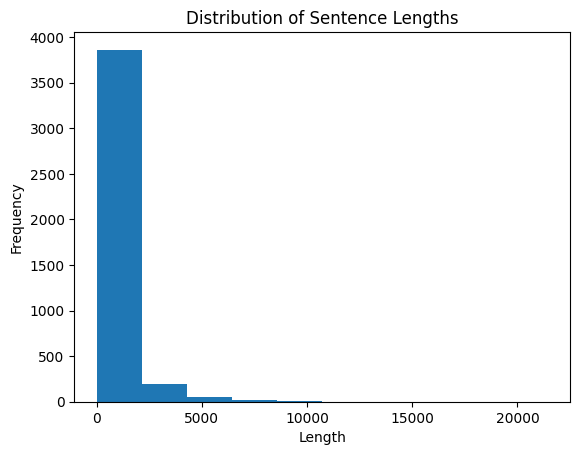

In [183]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# 문장 길이 계산
lengths = [len(sentence) for sentence in x_train]
mean_length = np.mean(lengths)
median_length = np.median(lengths)
print("Mean length:", mean_length)
print("Median length:", median_length)

# 히스토그램 시각화
plt.hist(lengths)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

### Tokenization

In [184]:
max_features = 500
max_seq_length = 100

# Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization and make a TextVectorization layer.
vectorize_layer = layers.TextVectorization(max_tokens=max_features, output_sequence_length=max_seq_length)
vectorize_layer.adapt(x_train)

print("x_train[0]:", x_train[0])
print("x_train[0]:", vectorize_layer(x_train[0]))

x_train[0]: Subject: meter 98 9699 98 2662 receipt meters w delivery noms anita delivery nom 22 mentioned meter 1 99 production receipt meter please explain purpose delivery nom receipt meter also situation 98 2662 1 99 also activity continuing 2 99 clem cernosek expressed delivery noms causing errors end spectrum forwarded jackie young hou ect 02 04 2000 02 31 pm lauri allen 02 04 2000 01 13 pm jackie young hou ect ect cc daren j farmer hou ect ect pat clynes corp enron enron subject meter 9699 jackie cannot life remember sale deal believe valid part purchase deal tesoro jill zively dealmaker could probably answer question could george weissman melissa graves might also check anita allocator see support gets allocation may give clue volume represents let know since hate forgetting things
x_train[0]: tf.Tensor(
[  3  13 285   1 285   1   1 321 175 223 219 453 223  80 168   1  13  12
  60  88   1  13   8   1   1 223  80   1  13  84   1 285   1  12  60  84
 300   1  14  60   1   1   1 22

### One-hot encoding (Use the vectorize layer that has been made above)

In [185]:
from tensorflow.keras.utils import to_categorical

# 훈련 데이터와 테스트 데이터를 토큰화
x_train_vl = vectorize_layer(x_train)
x_test_vl = vectorize_layer(x_test)

# 원-핫 인코딩 진행
# 스팸 or 스팸 X
x_train_oh = to_categorical(x_train_vl)
x_test_oh = to_categorical(x_test_vl)

print(x_train_oh[0])
print("x_train One-Hot encoding:", x_train_oh.shape)
print("x_test One-Hot encoding:", x_test_oh.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train_oh, y_train, test_size=0.2, random_state=42)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
x_train One-Hot encoding: (4136, 100, 500)
x_test One-Hot encoding: (1035, 100, 500)


### Make sequential model and evaluate it

In [193]:
from keras.models import Model

# Make a sequential model
inputs = layers.Input(shape = (100, 500))
simple_rnn = layers.SimpleRNN(2, activation='tanh')(inputs)
dense = layers.Dense(1, activation='sigmoid')(simple_rnn)
RNN_model = Model(inputs=inputs, outputs=dense)
RNN_model.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
RNN_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = RNN_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 100, 500)]        0         
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 2)                 1006      
                                                                 
 dense_29 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
104/104 [==============================] - 3s 20ms/step - loss: 0.6851 - accuracy: 0.6115 - val_loss: 0.6795 - val_accuracy: 0.6159
Epoch 2/20
104/104 [==============================] - 2s 18ms/step - loss: 0.6772 - accuracy: 0.6442 - val_loss: 0.6736 - val_accuracy: 0.6377
Epoch 3/20
104/104 [==============

### Plotting history

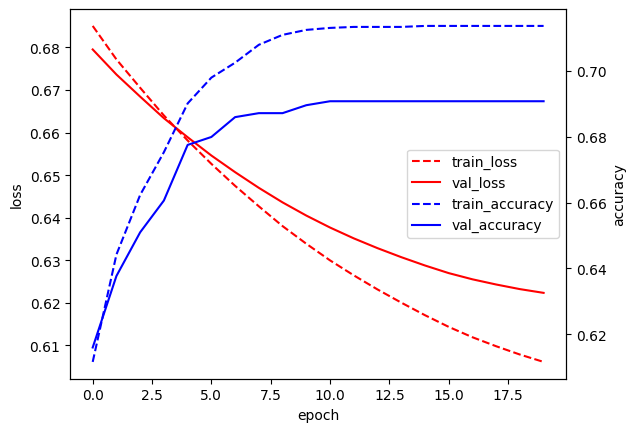

In [195]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#그림판 준비
fig, ax1 = plt.subplots()

# loss 그래프 ax1
ax1.plot(history.history['loss'], linestyle='--', color='red', label='train_loss')
ax1.plot(history.history['val_loss'], color='red', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

# accuracy 그래프 ax2
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], linestyle='--', color='blue', label='train_accuracy')
ax2.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
ax2.set_ylabel('accuracy')

# 이름표 합치기
loss, loss_label = ax1.get_legend_handles_labels()
acc, acc_label = ax2.get_legend_handles_labels()
ax1.legend(loss + acc, loss_label + acc_label, loc='center right')

# 출력!
plt.show()
